In [9]:
from datasets import load_dataset

import numpy as np
import pandas as pd
import transformers
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from huggingface_hub import login
import time
import datetime
import re
from tqdm import tqdm
from collections import defaultdict
from sentence_transformers import SentenceTransformer, util
import random

from sklearn.metrics.pairwise import cosine_similarity

import json
import ast


import matplotlib.pyplot as plt
import seaborn as sns






from openai import OpenAI


In [10]:
from huggingface_hub import login

API_TOKEN = ''

login(token = API_TOKEN)

In [11]:
ds_persona = load_dataset("proj-persona/PersonaHub", "persona")

In [12]:
ds_persona

DatasetDict({
    train: Dataset({
        features: ['persona'],
        num_rows: 200000
    })
})

In [13]:
api_key=""

## Testing word embeddings

### sentence transformer

In [51]:

gpt4o = pd.read_csv('../full_emotions/gpt4o.csv')
gpt4o_mini = pd.read_csv('../full_emotions/gpt4o_mini.csv')
llama33 = pd.read_csv('../full_emotions/llama33.csv')
llama31 = pd.read_csv('../full_emotions/llama31.csv')
qwen3_32B = pd.read_csv('../full_emotions/qwen3_32B.csv')
qwen3_30BA3B = pd.read_csv('../full_emotions/qwen3_30BA3B.csv')
enisear = pd.read_csv('../full_emotions/enisear.csv')


In [53]:
llama33_no_persona = pd.read_csv('../full_emotions/server_data/llama33_no_persona.csv')
llama31_no_persona = pd.read_csv('../full_emotions/server_data/llama31_no_persona.csv')

In [54]:


llama33_no_persona['Sentence'] = llama33_no_persona['Sentence'].apply(remove_emotions_and_i_felt)
llama31_no_persona['Sentence'] = llama31_no_persona['Sentence'].apply(remove_emotions_and_i_felt)

In [55]:
enisear["Dataset"] = "enISEAR"
llama31["Dataset"] = "LLaMa 3.1"
llama33["Dataset"] = "LLaMa 3.3"
llama31_no_persona["Dataset"] = "LLaMa 3.1 No Persona"
llama33_no_persona["Dataset"] = "LLaMa 3.3 No Persona"


In [56]:
results = pd.concat([
    enisear,
    llama31,
    llama33,
    llama31_no_persona,
    llama33_no_persona
], ignore_index=True)


In [57]:
def count_duplicates_all_datasets(results):
    duplicates = results[results['Sentence'].duplicated(keep=False)]

    duplicate_counts = duplicates['Dataset'].value_counts()

    return duplicate_counts


def count_duplicates_by_dataset_emotion(results):
    duplicates = results[results['Sentence'].duplicated(keep=False)]


    grouped_counts = duplicates.groupby(['Dataset', 'Prior_Emotion']).size().reset_index(name='Duplicate Count')

    return grouped_counts



In [58]:
dup_counts = count_duplicates_all_datasets(results)
dup_by_emotion = count_duplicates_by_dataset_emotion(results)


In [59]:
dup_counts

Dataset
LLaMa 3.3 No Persona    461
LLaMa 3.3                58
LLaMa 3.1 No Persona     14
enISEAR                   4
Name: count, dtype: int64

In [26]:

model = SentenceTransformer("all-mpnet-base-v2")


enisear_lst = enisear['Sentence'].dropna().tolist()

synth_33 = llama33['Sentence'].dropna().tolist()
synth_31 = llama31['Sentence'].dropna().tolist()

synth_33_no_persona = llama33_no_persona['Sentence'].dropna().tolist()
synth_31_no_persona = llama31_no_persona['Sentence'].dropna().tolist()

# Compute embeddings
embeddings_isear = model.encode(enisear_lst)

embeddings_33 = model.encode(synth_33)
embeddings_31 = model.encode(synth_31)

embeddings_33_no_persona = model.encode(synth_33_no_persona)
embeddings_31_no_persona = model.encode(synth_31_no_persona)




similarities_enisear = cosine_similarity(embeddings_isear)  

similarities_31 = cosine_similarity(embeddings_31)  
similarities_33 = cosine_similarity(embeddings_33)  

similarities_31_no_persona = cosine_similarity(embeddings_31_no_persona)  
similarities_33_no_persona = cosine_similarity(embeddings_33_no_persona)  


# Extract upper triangle values (unique pairs)

sim_enisear_values = similarities_enisear[np.triu_indices(len(enisear_lst), k=1)]

sim_31_values = similarities_31[np.triu_indices(len(synth_31), k=1)]
sim_33_values = similarities_33[np.triu_indices(len(synth_33), k=1)]


sim_31_values_no_persona = similarities_31_no_persona[np.triu_indices(len(synth_31_no_persona), k=1)]
sim_33_values_no_persona = similarities_33_no_persona[np.triu_indices(len(synth_33_no_persona), k=1)]

Variance in enISEAR all-mpnet-base-v2: 0.0226
Variance in synthetic (LlaMa 3.1 70B) all-mpnet-base-v2 : 0.0232
Variance in synthetic (LlaMa 3.3 70B) all-mpnet-base-v2 : 0.0223
Variance in synthetic (LlaMa 3.1 70B No Persona) all-mpnet-base-v2 : 0.0234
Variance in synthetic (LlaMa 3.3 70B No Persona) all-mpnet-base-v2 : 0.0268


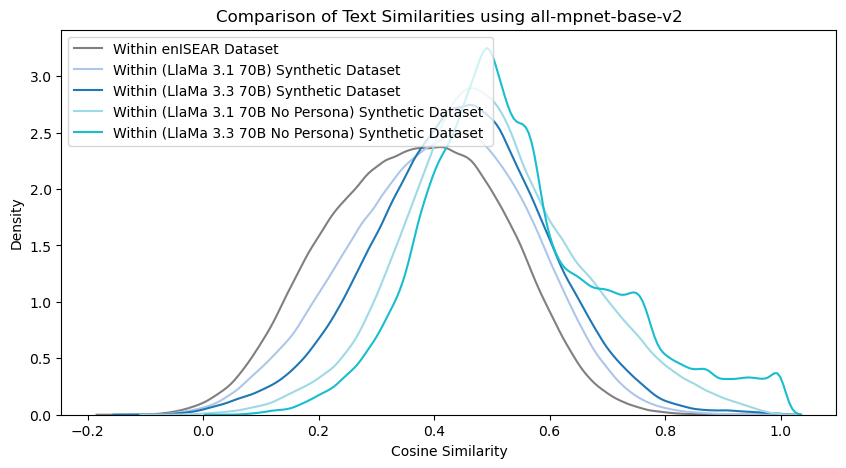

In [46]:

variance_isear = np.var(sim_enisear_values)

variance_31 = np.var(sim_31_values)
variance_33 = np.var(sim_33_values)

variance_31_no_persona = np.var(sim_31_values_no_persona)
variance_33_no_persona = np.var(sim_33_values_no_persona)


print(f"Variance in enISEAR all-mpnet-base-v2: {variance_isear:.4f}")
print(f"Variance in synthetic (LlaMa 3.1 70B) all-mpnet-base-v2 : {variance_31:.4f}")
print(f"Variance in synthetic (LlaMa 3.3 70B) all-mpnet-base-v2 : {variance_33:.4f}")


print(f"Variance in synthetic (LlaMa 3.1 70B No Persona) all-mpnet-base-v2 : {variance_31_no_persona:.4f}")
print(f"Variance in synthetic (LlaMa 3.3 70B No Persona) all-mpnet-base-v2 : {variance_33_no_persona:.4f}")

plt.figure(figsize=(10, 5))



# Plot within-ensiear similarities
sns.kdeplot(sim_enisear_values, label="Within enISEAR Dataset", color = 'grey')

# Plot within-female similarities
sns.kdeplot(sim_31_values, label="Within (LlaMa 3.1 70B) Synthetic Dataset ", color = '#aec7e8')

# Plot within-male similarities
sns.kdeplot(sim_33_values, label="Within (LlaMa 3.3 70B) Synthetic Dataset ", color = '#1f77b4')

# Plot within-female similarities
sns.kdeplot(sim_31_values_no_persona, label="Within (LlaMa 3.1 70B No Persona) Synthetic Dataset ", color = '#9edae5')

# Plot within-male similarities
sns.kdeplot(sim_33_values_no_persona, label="Within (LlaMa 3.3 70B No Persona) Synthetic Dataset ", color = '#17becf')




plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.title("Comparison of Text Similarities using all-mpnet-base-v2")
plt.legend()
plt.show()


In [29]:


def plot_similarity_heatmap(embeddings, title="Similarity Heatmap"):
    # Compute pairwise cosine similarity matrix
    sim_matrix = cosine_similarity(embeddings)

    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, cmap="viridis", xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.xlabel("Sentences")
    plt.ylabel("Sentences")
    plt.colorbar(label="Cosine Similarity")
    plt.tight_layout()
    plt.show()


In [ ]:


data = {
    "enISEAR": sim_enisear_values,
    "LLaMa 3.1": sim_31_values,
    "LLaMa 3.3": sim_33_values,
    "LLaMa 3.1 No Persona": sim_31_values_no_persona,
    "LLaMa 3.3 No Persona": sim_33_values_no_persona
}



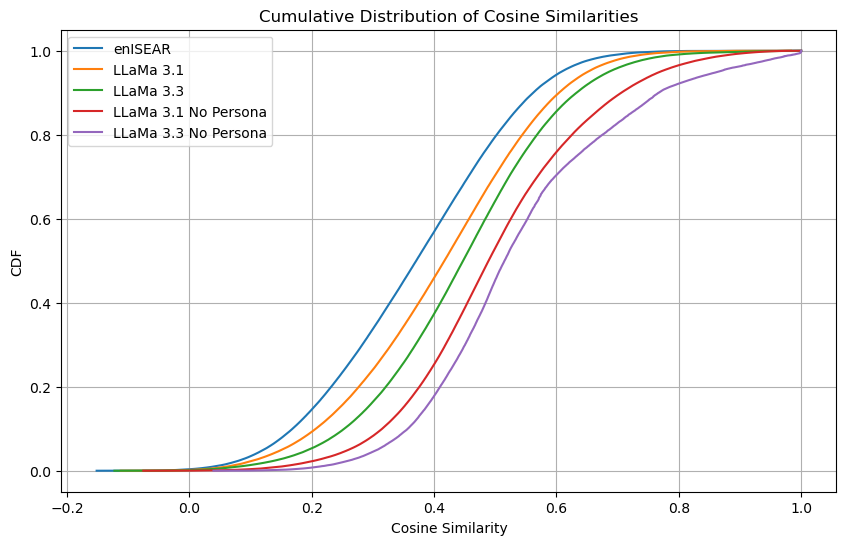

In [31]:
def plot_cdf(data_dict):
    plt.figure(figsize=(10, 6))
    for label, values in data_dict.items():
        sorted_vals = np.sort(values)
        cdf = np.arange(len(sorted_vals)) / float(len(sorted_vals))
        plt.plot(sorted_vals, cdf, label=label)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("CDF")
    plt.title("Cumulative Distribution of Cosine Similarities")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cdf(data)


In [49]:


summary_stats = []

for name, values in data.items():
    stats = {
        "Dataset": name,
        "Mean": np.mean(values),
        "Median": np.median(values),
        "Std": np.std(values),
        "Min": np.min(values),
        "25th %": np.percentile(values, 25),
        "75th %": np.percentile(values, 75),
        "95th %": np.percentile(values, 95),
        "Max": np.max(values)
    }
    summary_stats.append(stats)


stats_df = pd.DataFrame(summary_stats)

stats_df = stats_df.round(4)

print(stats_df.to_string(index=False))


             Dataset   Mean  Median    Std     Min  25th %  75th %  95th %    Max
             enISEAR 0.3681  0.3707 0.1502 -0.1517  0.2581  0.4781  0.6081 1.0000
           LLaMa 3.1 0.4108  0.4169 0.1523 -0.1123  0.3049  0.5203  0.6513 0.9832
           LLaMa 3.3 0.4448  0.4474 0.1495 -0.1226  0.3467  0.5440  0.6860 1.0000
LLaMa 3.1 No Persona 0.4994  0.4890 0.1529 -0.0753  0.3985  0.5947  0.7695 1.0000
LLaMa 3.3 No Persona 0.5409  0.5150 0.1637  0.0393  0.4310  0.6337  0.8642 1.0000


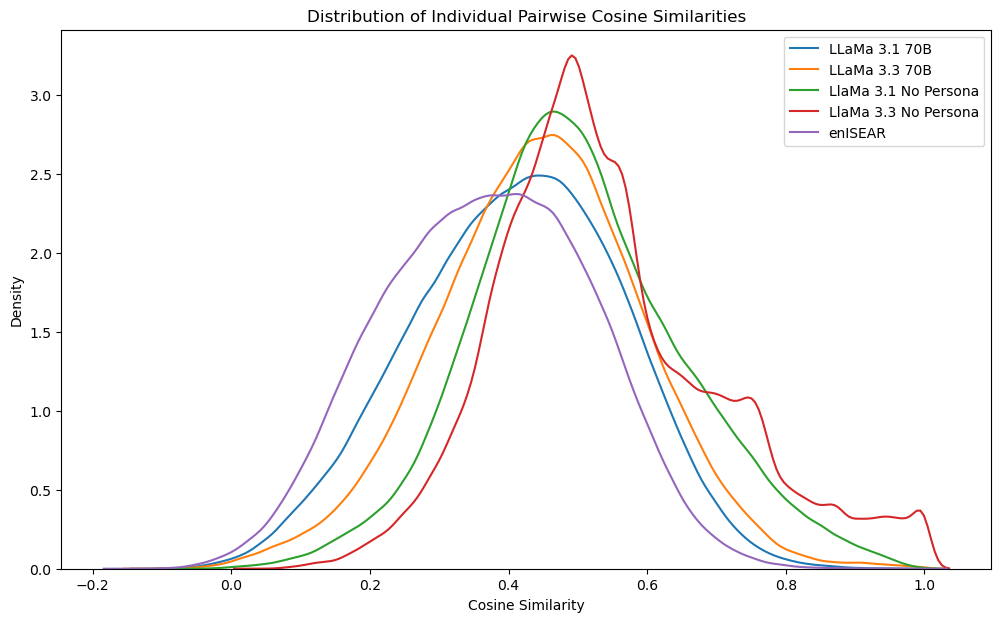

In [33]:

# List of pairs to compare
embedding_pairs = [
    ("LLaMa 3.1 70B", embeddings_31),
    ("LLaMa 3.3 70B", embeddings_33),
    ("LlaMa 3.1 No Persona", embeddings_31_no_persona),
    ("LlaMa 3.3 No Persona", embeddings_33_no_persona),
    ("enISEAR", embeddings_isear)
]

plt.figure(figsize=(12, 7))

# Plot distributions
for name, embeddings in embedding_pairs:
    sim_matrix = cosine_similarity(embeddings)
    upper_triangle_values = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    sns.kdeplot(upper_triangle_values, label=f"{name}")

plt.title("Distribution of Individual Pairwise Cosine Similarities")
plt.xlabel("Cosine Similarity")
plt.ylabel("Density")
plt.legend()
plt.show()
